In [1]:
from sstadex import Macromodel, Primitive, dfs, simplediffpair, cs_pmos, cm_pmos, spice_sim
import numpy as np
from sympy import Symbol
from sympy.solvers import solve
import matplotlib.pyplot as plt
import paretoset as pareto
import pandas as pd
from sympy import lambdify

XSCHEM_RCFILE = "/opt/pdks/sky130A/libs.tech/xschem/xschemrc"
SPICE_DIR = "./spice/"
OUTPUT_DIR = "./output/"
XSCHEM_DIR = "./xschem/"

In [2]:
class test:
    def __init__(self) -> None:
        pass
    def eval(funct):
        return {"eval": funct}

In [3]:
## Exploration parameters

N_points = 10
lengths = [0.4e-06, 0.8e-06, 1.6e-06, 3.2e-06, 6.4e-6]

## Electrical parameters

Vout = 1.2                                     # LDO output voltage
Vin = 1.8                                      # LDO supply voltage
Vref = 0.9                                     # LDO voltage reference
IL = 100e-3                                      # Load current
CL = 50e-12                                        # Load capacitance
RL = Vout/IL

## LDO specifications
    
psrr_condition = -60
estability_condition = 80
linereg_condition = 0.5
loadreg_condition = 0.7
iq_condition = 20e-6
size_condition = 1e-3

# Initial macros

In [22]:
## LDO MACROMODEL

Vg = np.linspace(Vin - (Vin - Vout), 1.8, 5)

LDO_macro = Macromodel(name = "ldo",
                       outputs = [Symbol("W")],
                       electrical_parameters = {"Vdd": Vin, 
                                                "Vref": Vref, 
                                                "Vout": Vout, 
                                                "Vaout": 1.05,
                                                "Il": IL} 
                       )

## 2stage_OTA MACROMODEL

Vg_ota = np.linspace(LDO_macro.electrical_parameters["Vdd"] - (LDO_macro.electrical_parameters["Vdd"] - LDO_macro.electrical_parameters["Vaout"]), LDO_macro.electrical_parameters["Vdd"], 5)

stage2_OTA_macro = Macromodel(name = "stage2_OTA",
                              outputs=[Symbol("W")],
                              macromodel_parameters={Symbol('Ra'): np.logspace(3, 7, N_points),
                                                     Symbol('gma'): np.logspace(-5, -2, N_points),
                                                     Symbol('Ca'): np.logspace(-17, -12, N_points)},
                              electrical_parameters = {"Vdd": LDO_macro.electrical_parameters["Vdd"], 
                                                       "Vneg": LDO_macro.electrical_parameters["Vref"], 
                                                       "Vpos": LDO_macro.electrical_parameters["Vref"], 
                                                       "Vout": LDO_macro.electrical_parameters["Vaout"],
                                                       "Vaouts1": 0.95}
                              )

## 1stage_OTA MACROMODEL

OTA_macro = Macromodel(name = "ota_cap",
                       req_tfs = [["vout", "vpos"], ["vout", "vpos"]],
                       macromodel_parameters={Symbol('Ra_1stage'): np.logspace(3, 7, N_points),
                                              Symbol('gma_1stage'): np.logspace(-5, -2, N_points),
                                              Symbol('Ca_1stage'): np.logspace(-17, -12, N_points)},
                       electrical_parameters={Symbol("gdif_2"): Symbol("gdif_1"),
                                              Symbol("Rdif_2"): Symbol("Rdif_1")}
                      )

# Primitives

In [23]:
## PASS TRANSISTOR MACROMODEL

pt = cs_pmos(netlist='pmos_cm.spice', 
             type='pmos', 
             inputs={'vds_lut': LDO_macro.electrical_parameters["Vout"]-LDO_macro.electrical_parameters["Vdd"], 
                     'vgs_lut': (-1.8, -0.1, 0.01), 
                     'vgs': LDO_macro.electrical_parameters["Vaout"]-LDO_macro.electrical_parameters["Vdd"], 
                     'il': LDO_macro.electrical_parameters["Il"],
                     'length': lengths, 
                     '2d_var': ['length', 'vgs']})

pt.build()

pt.parameters = {Symbol('gm_pt'): np.asarray(pt.gm).flatten(),
                 Symbol('Ro_pt'): np.asarray(pt.Ro/(IL/20e-6)).flatten()}
pt.outputs = {Symbol("W"): np.asarray(pt.W).flatten()}

## OTA stage2 transistor MACROMODEL

stage2_t = cs_pmos(netlist='pmos_cm.spice', 
                   type='pmos', 
                   inputs={'vds_lut': stage2_OTA_macro.electrical_parameters["Vout"]-stage2_OTA_macro.electrical_parameters["Vdd"], 
                           'vgs_lut': (-1.8, -0.1, 0.01), 
                           'vgs': stage2_OTA_macro.electrical_parameters["Vaouts1"]-stage2_OTA_macro.electrical_parameters["Vdd"], 
                           'il': 20e-6,
                           'length': lengths, 
                           '2d_var': ['length', 'vgs']})
stage2_t.build()

stage2_t.parameters = {Symbol('gm_stage2'): np.asarray(stage2_t.gm).flatten(),
                 Symbol('Ro_stage2'): np.asarray(stage2_t.Ro).flatten()}
stage2_t.outputs = {Symbol("W"): np.asarray(stage2_t.W).flatten()}

## OTA stage1 differential pair

vs = np.linspace(0.1, 0.8, 20)
vds_diffpar = stage2_OTA_macro.electrical_parameters["Vaouts1"] - vs
vgs_diffpar = stage2_OTA_macro.electrical_parameters["Vpos"] - vs

diffpair_primitive = simplediffpair(netlist='simplediffpair.spice', type='nmos', inputs={'vds_lut': (0.1, 1.2, 0.01), 'vgs_lut': (0.1, 1.8, 0.01), 'vds': vds_diffpar, 'vgs': vgs_diffpar, 'il': 20e-6,
                  'length': lengths, '2d_var': ['vds', 'vgs']})

diffpair_primitive.build()      

diffpair_primitive.parameters = {Symbol("Rdif_1"): np.asarray(diffpair_primitive.Ro).flatten(), 
                                 Symbol("gdif_1"): np.asarray(diffpair_primitive.gm).flatten(),
                                 Symbol("Cgd"): np.asarray(diffpair_primitive.cgd).flatten(),
                                 Symbol("Cgs"): np.asarray(diffpair_primitive.cgs).flatten()}

## OTA stage1 active load

ota_cm_pmos = cm_pmos(name='ota_cm_pmos', 
                      netlist='pmos_cm.spice', 
                      type='pmos', 
                      inputs={'vds_lut': stage2_OTA_macro.electrical_parameters["Vaouts1"]-stage2_OTA_macro.electrical_parameters["Vdd"], 
                              'vgs_lut': (-1.8, -0.1, 0.01), 
                              'vgs': stage2_OTA_macro.electrical_parameters["Vaouts1"]-stage2_OTA_macro.electrical_parameters["Vdd"], 
                              'il': 20e-6,
                              'length': lengths, 
                              '2d_var': ['length', 'vgs']})
ota_cm_pmos.build()

ota_cm_pmos.parameters = {Symbol("Raload_1"): np.asarray(ota_cm_pmos.Ro).flatten(),
                          Symbol("Raload_2"): 1/np.asarray(ota_cm_pmos.gm).flatten(),
                          Symbol("gaload"): np.asarray(ota_cm_pmos.gm).flatten()}

length
vgs
0
length
vgs
0
vds
vgs
1
length
vgs
0


# Specifications

In [32]:
## LDO MACROMODEL

#################### PSRR LDO MACRO #######################
psrr_LDO_macro = test()
psrr_LDO_macro.tf = ["vout", "vdd"]
psrr_LDO_macro.netlist = "ldo.spice"
psrr_LDO_macro.parametros = {Symbol("V1"): 1,
                   Symbol("V2"): 0,
                   Symbol("s"): 0,
                   Symbol("Rl"): RL,
                   Symbol("Cl"): CL,
                   Symbol("Cc"): 1e-12,
                   Symbol("R1"): 100000,
                   Symbol("R2"): 300000}

psrr_LDO_macro.conditions = {"max": [-70]}
psrr_LDO_macro.variables = {}
psrr_LDO_macro.out_def = {"eval": psrr_LDO_macro.tf}

#################### BW LDO MACRO #######################
bw_LDO_macro = test()
bw_LDO_macro.tf = ["vout", "vdd"]
bw_LDO_macro.netlist = "ldo.spice"
bw_LDO_macro.parametros = {Symbol("V1"): 1,
                  Symbol("V2"): 0,
                  Symbol("Rl"): RL,
                  Symbol("Cl"): CL,
                   Symbol("Cc"): 1e-12,
                  Symbol("R1"): 100000,
                  Symbol("R2"): 300000}
bw_LDO_macro.conditions = {"min": [1e4]}
bw_LDO_macro.variables = {}
bw_LDO_macro.out_def = {"eval": bw_LDO_macro.tf}

#################### load regulation LDO MACRO #######################
loadreg_LDO_macro = test()
loadreg_LDO_macro.tf = ["vout", "vdd"]
psrr_LDO_macro.netlist = "ldo.spice"
loadreg_LDO_macro.parametros = {Symbol("V1"): 1.8,
                      Symbol("V2"): 0.9,
                      Symbol("s"): 0,
                      Symbol("Cl"): CL,
                      Symbol("Cc"): 1e-12,
                      Symbol("R1"): 100000,
                      Symbol("R2"): 300000}
loadreg_LDO_macro.variables = {Symbol('Rl'): [RL, RL+1200]}
loadreg_LDO_macro.out_def = {'diff': [loadreg_LDO_macro.tf, loadreg_LDO_macro.variables]}
loadreg_LDO_macro.conditions = {'max': [1]}

## 2stage_OTA MACROMODEL

#################### PSRR 2 stage OTA #######################
psrr_2stage_OTA = test()
psrr_2stage_OTA.tf = ["vout", "V_p"]
psrr_2stage_OTA.netlist = "2stage_OTA.spice"
psrr_2stage_OTA.parametros = {Symbol("V1"): 0,
                   Symbol("V2"): 1,
                   Symbol("V3"): 0,
                   Symbol("Il"): 0, 
                   Symbol("I2"): 0,
                   Symbol("Cl"): 0,
                   Symbol("s"): 0}
psrr_2stage_OTA.variables = {}
psrr_2stage_OTA.out_def = {"eval": psrr_2stage_OTA.tf}
 
#################### BW 2 stage OTA #######################
bw_2stage_OTA = test()
bw_2stage_OTA.tf = ["vout", "V_p"]
bw_2stage_OTA.netlist = "2stage_OTA.spice"
bw_2stage_OTA.parametros = { Symbol("V1"): 0,
                   Symbol("V2"): 1,
                   Symbol("V3"): 0,
                   Symbol("Il"): 0,
                   Symbol("I2"): 0,
                   Symbol("Cl"): 1e-12}
bw_2stage_OTA.variables = {}
bw_2stage_OTA.out_def = {"eval": bw_2stage_OTA.tf}

#################### rout 2 stage OTA #######################
rout_2stage_OTA = test()
rout_2stage_OTA.tf = ["vout", "vr"]
bw_2stage_OTA.netlist = "2stage_OTA_r.spice"
rout_2stage_OTA.parametros = {Symbol("V1"): 0,
                   Symbol("V2"): 0,
                   Symbol("V3"): 0,
                   Symbol("V4"): 1,
                   Symbol("Ra_1"): 1000,
                   Symbol("I2"): 0,
                   Symbol("Cl"): 0,
                   Symbol("s"): 0}
rout_2stage_OTA.variables = {}
rout_2stage_OTA.out_def = {"eval": rout_2stage_OTA.tf}

## 1stage_OTA MACROMODEL

#################### PSRR 1stage OTa #######################
psrr_1stage_OTA = test()
psrr_1stage_OTA.tf = ("vout", "vpos")
psrr_1stage_OTA.netlist = "1stage_OTA.spice"
psrr_1stage_OTA.parametros = {Symbol("gdif_2"): Symbol("gdif_1"),
                   Symbol("Rdif_2"): Symbol("Rdif_1"),
                   Symbol("V1"): 0,
                   Symbol("V_n"): 0,
                   Symbol("V_p"): 1,
                   Symbol("I2"): 0,
                   Symbol("s"): 0,
                   Symbol("Cl"): 1e-12}

psrr_1stage_OTA.conditions = {"min": [40]}
psrr_1stage_OTA.variables = {}
psrr_1stage_OTA.out_def = {"eval": psrr_1stage_OTA.tf}

#################### BW 1stage OTA #######################

bw_1stage_OTA = test()
bw_1stage_OTA.tf = ("vout", "vpos")
bw_1stage_OTA.netlist = "1stage_OTA.spice"
bw_1stage_OTA.parametros = {Symbol("gdif_2"): Symbol("gdif_1"),
                   Symbol("Rdif_2"): Symbol("Rdif_1"),
                   Symbol("V1"): 0,
                   Symbol("V_n"): 0,
                   Symbol("V_p"): 1,
                   Symbol("I2"): 0,
                   Symbol("Cl"): 1e-12}
bw_1stage_OTA.variables = {}
bw_1stage_OTA.out_def = {"eval": bw_1stage_OTA.tf}

#################### rout 1 stage OTA #######################
rout_1stage_OTA = test()
rout_1stage_OTA.tf = ["vout", "vr"]
rout_1stage_OTA.netlist = "1stage_OTA_r.spice"
rout_1stage_OTA.parametros = {Symbol("gdif_2"): Symbol("gdif_1"),
                   Symbol("Rdif_2"): Symbol("Rdif_1"),
                   Symbol("V1"): 0,
                   Symbol("V_n"): 0,
                   Symbol("V_p"): 0,
                   Symbol("Vr"): 1,
                   Symbol("I2"): 0,
                   Symbol("s"): 0,
                   Symbol("Rr"): 1000,
                   Symbol("Cl"): 1e-12}
rout_1stage_OTA.variables = {}
rout_1stage_OTA.out_def = {"eval": rout_1stage_OTA.tf}

# Sizes

# Exploration

In [ ]:
LDO_macro.primitives = [pt]
LDO_macro.submacromodels = [stage2_OTA_macro]
LDO_macro.num_level_exp = -1
LDO_macro.specifications = [psrr_LDO_macro]

stage2_OTA_macro.primitives = [stage2_t]
stage2_OTA_macro.submacromodels = [OTA_macro]
stage2_OTA_macro.num_level_exp = 1
stage2_OTA_macro.specifications = [psrr_2stage_OTA]

ldo_results, ldo_axes, ldo_primouts = dfs(LDO_macro, debug = True)

############################################
Starting the exploration of:  ldo
Running MNA... 



   X server connection failed, although DISPLAY shell variable is set.
   A possible reason is that the X server is not running or DISPLAY shell variable
   is incorrectly set.
   Starting Xschem in text only mode.



   vdd  vout  net1  vfb  vss  net2
0    1     2     3    4    0     5
[['vout', 'vdd']]
A:  Matrix([[Ca*s + gm_pt + 1/Ro_pt + 1/Ra, -1/Ro_pt, -Ca*s - gm_pt - 1/Ra, gma, -gma, 1, 0], [-gm_pt - 1/Ro_pt, Cc*s + Cl*s + 1/Ro_pt + 1/Rl + 1/R1, -Cc*s + gm_pt, -1/R1, 0, 0, 0], [-Ca*s - 1/Ra, -Cc*s, Ca*s + Cc*s + 1/Ra, -gma, gma, 0, 0], [0, -1/R1, 0, 1/R2 + 1/R1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0]])
[v1, v2, v3, v4, v5, I_V1, I_V2]
{I_V1: (-Ca*Cc*Cl*R1*Ra*Rl*Ro_pt*V1*s**3 - Ca*Cc*Cl*R2*Ra*Rl*Ro_pt*V1*s**3 - Ca*Cc*R1*Ra*Ro_pt*V1*s**2 - Ca*Cc*R2*Ra*Ro_pt*V1*s**2 - Ca*Cc*Ra*Rl*Ro_pt*V1*s**2 - Ca*Cl*R1*Ra*Rl*V1*s**2 - Ca*Cl*R2*Ra*Rl*V1*s**2 - Ca*R1*Ra*V1*s - Ca*R2*Ra*V1*s - Ca*Ra*Rl*V1*s - Cc*Cl*R1*Ra*Rl*Ro_pt*V1*gm_pt*s**2 + Cc*Cl*R1*Ra*Rl*Ro_pt*V2*gma*s**2 - Cc*Cl*R1*Ra*Rl*V1*s**2 - Cc*Cl*R1*Rl*Ro_pt*V1*s**2 - Cc*Cl*R2*Ra*Rl*Ro_pt*V1*gm_pt*s**2 + Cc*Cl*R2*Ra*Rl*Ro_pt*V2*gma*s**2 - Cc*Cl*R2*Ra*Rl*V1*s**2 - Cc*Cl*R2*Rl*Ro_pt*V1*s**2 - Cc*R1*Ra*Ro_pt*V1*gm_

In [30]:
W_ldo = ldo_primouts[0][0]

gain_ldo = 20*np.log10(np.abs(ldo_results[0].flatten()))

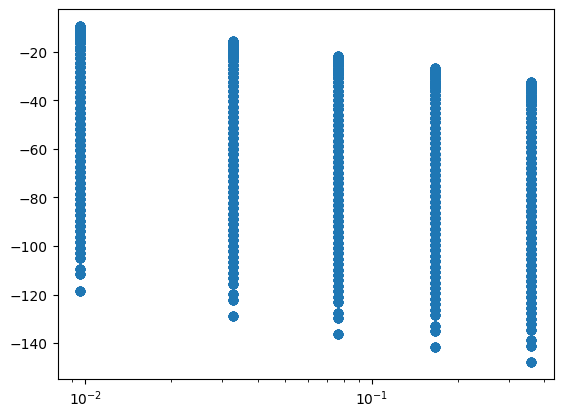

In [31]:
plt.scatter(W_ldo, gain_ldo)
plt.xscale('log')